# YouView task

The object of the exercise is to analyse the supplied data set to define a set of clusters based on the on-demand viewing behaviour of the 10,000 set-top-box devices, and to place each device into one of these clusters. You are then asked to use the output of this analysis to draw simple insights to help the business understand customer behaviour. The exercise should take two to three hours to complete, and it is expected that you will complete this work in Python or R.

In [153]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load up and prepare the data

In [154]:
#Load up data from CSV
df = pd.read_csv('YouView Recruitment Test Data Set v02.csv')

In [155]:
#CLEAN DATA 1 - drop NAN values - record number of lost values
old_len = len(df)
df = df.dropna()
new_len = len(df)
print '{} NAN values dropped'.format(old_len-new_len)

5 NAN values dropped


In [156]:
#Mapping fucntion
def seq(x):
    if (x==applications[0]):
        x = 1
    elif (x==applications[1]):
        x=2
    elif (x==applications[2]):
        x=3
    elif (x==applications[3]):
        x=4
    elif (x==applications[4]):
        x=5
    elif (x==applications[5]):
        x=6
    elif (x==applications[6]):
        x=7
    elif (x==applications[7]):
        x=8
    elif (x==applications[8]):
        x=9
    elif (x==applications[9]):
        x=10
    elif (x==applications[10]):
        x=11
    elif (x==applications[11]):
        x=12
    elif (x==applications[12]):
        x=13
    return x

In [157]:
#CLEAN DATA 2 - drop ID column and replace application name with a float
applications = df['application name'].unique()
df_prep = df.drop('device id', 1)
df_prep['application name'] = df_prep['application name'].map(lambda x: seq(x))

# Exploratory work

Produce simple bar charts to explore the data

In [158]:
#Create dictionary of means
mean_min = {}
for i in range(len(applications)):
    DF = df.groupby('application name').get_group(applications[i])
    mean = DF['weekly minutes of content played'].mean()
    mean_min[applications[i]]=mean

mean_min = OrderedDict(sorted(mean_min.items(), key=lambda x: x[0]))

#Create dictionary of length
len_min = {}
for i in range(len(applications)):
    DF = df.groupby('application name').get_group(applications[i])
    length = len(DF['weekly minutes of content played'])
    len_min[applications[i]]=length

len_min = OrderedDict(sorted(len_min.items(), key=lambda x: x[0]))

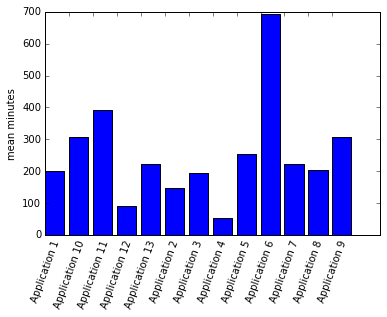

In [159]:
#PLOT means
plt.figure()
index = np.arange(len(applications))
plt.bar(index,mean_min.values())
plt.xticks(index,mean_min.keys(),rotation=70)
plt.ylabel('mean minutes')

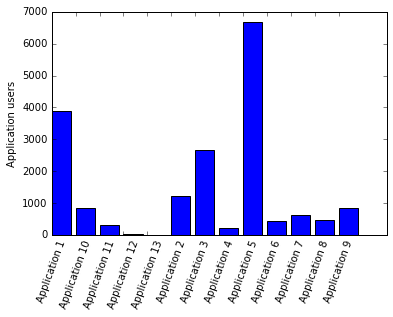

In [160]:
#PLOT means
plt.figure()
index = np.arange(len(applications))
plt.bar(index,len_min.values())
plt.xticks(index,len_min.keys(),rotation=70)
plt.ylabel('Application users')

CONCLUSIONS: 
- The majority of users are using Applications 1,2,3 and 4. 
- Application 6 is used for the longest time (on average). 
- Application 4 is used for the shortest time (on average).

# K-Means clustering

Note: I have not carried out a K-means clustering analysis prior to this assesment and as a result am unfamiliar with many of parameters and reliability tests. The majority of this work is based on the SKLearn K-Means analysis example: cite:http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

FIRST METHOD:

Using the script provided by SKLearn. They conduct a PCA. Whilst this is succesful with the YouView data set, I lack significant understanding of PCA to reliably defend this method, or interpret it's results. 

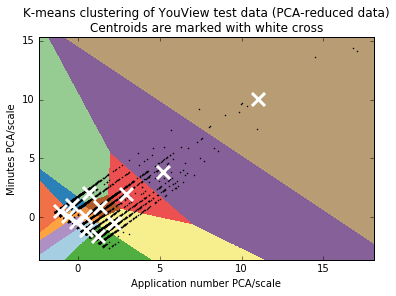

In [161]:
#PCA clustering method
data = scale(df_prep,axis=0)
n_samples,n_feature = data.shape
n_digits = len(applications)

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering of YouView test data (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Application number PCA/scale')
plt.ylabel('Minutes PCA/scale')
#plt.xticks(())
#plt.yticks(())
plt.show()

SECOND METHOD:

Adapting the SKLearn method, I simplify the clustering algorithm to randomly select centroids from the scaled data.
The number of clusters is deffined by the number of application types though there is a lot of flexibility here.

Clustering shows a startification by minutes. 
- Two large cluster are present across all Applications at higher values.
- At medium minutes values Applications are split into batches of 3, clustering: Applications 1,2 & 3, Applications 5, 6 & 7, and Applications 8,9,10 & 11.
- At the lowest minutes values there are 5 clusters where all applications are represented. 


In [162]:
#KMEANS clustering with scaling. Cite:http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
data = scale(df_prep)
n_samples,n_feature = data.shape
n_digits = len(applications)

kmeans = KMeans(init='random', n_clusters=n_digits, n_init=10)
kmeans.fit(data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

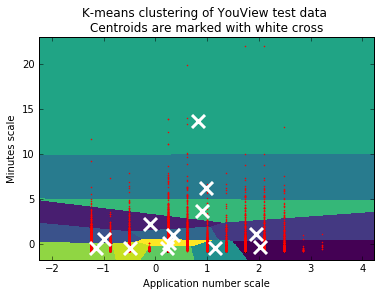

In [163]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
#Plot colour scale mesh
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.viridis,
           aspect='auto', origin='lower')
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
#Plot data
plt.plot(data[:, 0], data[:, 1], 'r.', markersize=2)

plt.title('K-means clustering of YouView test data \n'
          'Centroids are marked with white cross')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.xlabel('Application number scale')
plt.ylabel('Minutes scale')
#plt.xticks(())
#plt.yticks(())
plt.show()

# Dimensionality reduction.

Noting the numerical dominance of 4 applications, I group the data by Aplications 1, 2, 3 & 5 and re-run the random clustering to see if this produces more consistent clustering. 

The answer is no. There is no real pattern to be deciphered from these dominant parts, with two of the cluster centres lying well off of the actual data. Clearly using all the data leads to more useful clusters.

In [164]:
#Run clustering with reduced data set.
#Take only dat from Applications 1,2,3 & 5 (as they are the largest) 

df_reduced_1 = df_prep.groupby('application name').get_group(1)
df_reduced_2 = df_prep.groupby('application name').get_group(2)
df_reduced_3 = df_prep.groupby('application name').get_group(3)
df_reduced_5 = df_prep.groupby('application name').get_group(5)
df_reduced = pd.concat([df_reduced_1,df_reduced_2,df_reduced_3,df_reduced_5])

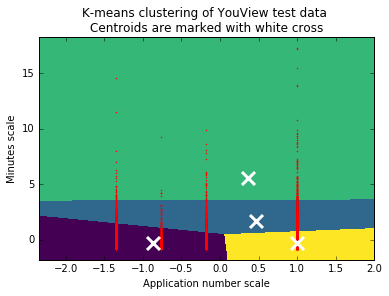

In [165]:
#KMEANS clustering with scaling. Cite:http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
data = scale(df_reduced)
n_samples,n_feature = data.shape
n_digits = 4

kmeans = KMeans(init='random', n_clusters=n_digits, n_init=50)
kmeans.fit(data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
#Plot colour scale mesh
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.viridis,
           aspect='auto', origin='lower')
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
#Plot data
plt.plot(data[:, 0], data[:, 1], 'r.', markersize=2)

plt.title('K-means clustering of YouView test data \n'
          'Centroids are marked with white cross')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.xlabel('Application number scale')
plt.ylabel('Minutes scale')
#plt.xticks(())
#plt.yticks(())
plt.show()

# Conclusions

I conclude that there is little useful information that can be gained from this clustering analysis. K-Means tends to cluster across the minutes used, which often leads to confliction with the discrete Applications list. This most information comes from clustering by application showed in the data exploration part of the task. 